# RuvB energetic analysis comparing different references

In [1]:
import tools.load as load
import tools.spatial as spatial
import tools.sequence as seq
import tools.elastic as elastic

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from matplotlib import cm
from matplotlib import animation

import seaborn as sns
from scipy.cluster.hierarchy import linkage

import warnings
import string
import time
from os import listdir as ls
from numba import jit

import pymol2
from pymol import stored

from scipy.stats import kruskal, mannwhitneyu, wilcoxon

warnings.filterwarnings('ignore')

#print(rcParams.keys())

WIDTH = 3+3/8
TICK_SIZE = 6
FONT_SIZE = 8
LEGEND_SIZE = 6
TITLE_SIZE = 8

plt.rc("font", size = FONT_SIZE)
plt.rc("figure", titlesize = TITLE_SIZE)
plt.rc("xtick", labelsize = TICK_SIZE)
plt.rc("ytick", labelsize = TICK_SIZE)
plt.rc("axes", titlesize = TITLE_SIZE, labelsize = FONT_SIZE)
plt.rc("legend", fontsize = LEGEND_SIZE, frameon = False)

axis_Eel = "Elastic energy, $E_{\\rm el}$ $(kT)$"
axis_Eel_short = "El. energy, $E_{\\rm el}$ $(kT)$"

## Loading

We begin by loading the polypeptides of all the structures

In [2]:
# Input
s_ref = ["s0-At2", "7PBQ", "8EFV", "AF_model", "AF_model_DNA"]
s_cycle = ['s1t2', 's2t2', 's3t2', 's4t2', 's5t2']

# Set a vector to describe the chains names
chain_names = list(load.char_range('A','F'))[::-1]

# Compute
s_pps_ref = []
s_pps_cycle = []

for name, ft in zip(s_ref, ["pdb", "pdb", "pdb", "cif", "cif"]):
    structure = load.single_structure(name, chain_ids=chain_names, file_type = ft)
    s_pps_ref.append(structure)

for name in s_cycle:
    structure = load.single_structure(name, chain_ids=chain_names)
    s_pps_cycle.append(structure)


## Structure labeling and visualization

In [3]:
states_names = ['s' + str(i+1) for i in range(len(s_pps_cycle))]
state_chain_names = []
state_chain_names_short = []
for name in chain_names:
    for i in range(len(s_pps_cycle)):
        state_chain_names.append(name + str(i+1))
        if i == 0:
            state_chain_names_short.append(name + str(i+1))
        else:
            state_chain_names_short.append("")

In [4]:
xyz_r, labels_r = load.coordinates_all_atoms(s_pps_ref[0])

# Indexes of chains' atoms
chain_idx = load.chain_indices(chain_names, labels_r)
chain_colors = ["tab:red", "tab:purple", "tab:blue", "tab:green", "tab:olive", "tab:orange"]

chain_colors = chain_colors[::-1]

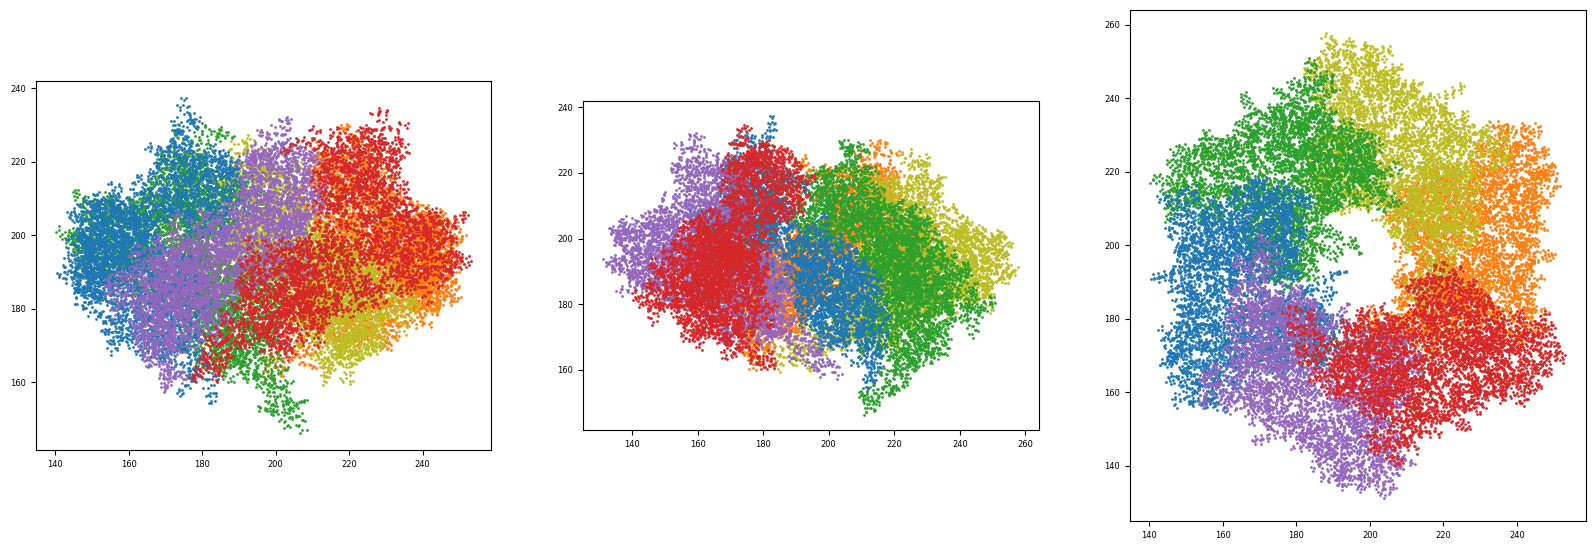

In [5]:
fig = plt.figure(figsize=(20, 10), dpi=100)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for idx, col in zip(chain_idx, chain_colors):
    xs, ys, zs = xyz_r[idx,0], xyz_r[idx,1], xyz_r[idx,2]

    ax1.scatter(xs, zs, s=1, color = col)
    ax2.scatter(ys, zs, s=1, color = col)
    ax3.scatter(xs, ys, s=1, color = col)

ax1.axis('scaled')
ax2.axis('scaled')
ax3.axis('scaled')
plt.show()

## Defining the set of common residues and common atoms

In [6]:
xyz_ref = []
xyz_cycle = []
labels = []
chain_idx = []

for i in range(len(s_pps_ref)):
    uni_ids = [None] * 1
    
    my_ref_seqs = seq.generate_reference([s_pps_ref[i][0]], uni_ids)

    
    indexes = []
    labels_hex = []
    labels_mon = []
    labels_hex_at = []
    labels_mon_at = []

    s_pps = [s_pps_ref[i]] + s_pps_cycle
    for j in range(len(s_pps)):
        temp = dict()
        temp_at = dict()
        
        for k in range(len(s_pps[j])):
            temp2 = seq.aligned_dict([s_pps[j][k]], seq.align([s_pps[j][k]], my_ref_seqs))
            temp2_at = seq.aligned_dict_all_atoms([s_pps[j][k]], seq.align([s_pps[j][k]], my_ref_seqs))

            temp.update(temp2)
            temp_at.update(temp2_at)

            labels_mon.append(temp2)
            labels_mon_at.append(temp2_at)
        
        labels_hex.append(temp)
        labels_hex_at.append(temp_at)

    com_res = seq.common_multiple(labels_mon)
    com_at = seq.common_multiple(labels_mon_at)
    
    # Get the position of all atoms
    xyz_cycle.append([])
    labels.append([])
    
    for j in range(len(s_pps_cycle)):
        t1, t2 = load.coordinates_backbone(s_pps_cycle[j], com_at, labels_hex_at[j+1])
        #t1, t2 = load.coordinates(s_pps_cycle[j], com_res, labels_hex[j+1])
        xyz_cycle[i].append(t1)
        labels[i].append(t2)
    
    t1, t2 = load.coordinates_backbone(s_pps_ref[i], com_at, labels_hex_at[0])
    #t1, t2 = load.coordinates(s_pps_ref[i], com_res, labels_hex[0])
    xyz_ref.append(t1)
    
    print(len(com_res))

308
308
295
308
308


In [7]:
# Invert the order of chains from FEDCBA to ABCDEF

for i in range(len(s_pps_ref)):
    if s_ref[i] in ["AF_model", "AF_model_DNA"]:
        s = len(xyz_ref[i])//6
        
        reordA = np.array(xyz_ref[i][5*s:6*s], dtype = "object")
        #reordB = np.array(xyz_ref[i][4*s:5*s], dtype = "object")
        reordC = np.array(xyz_ref[i][3*s:4*s], dtype = "object")
        reordD = np.array(xyz_ref[i][2*s:3*s], dtype = "object")
        #reordE = np.array(xyz_ref[i][s:2*s], dtype = "object")
        reordF = np.array(xyz_ref[i][:s], dtype = "object")

        xyz_ref[i][:s] = reordD
        #xyz_ref[i][s:2*s] = reordE
        xyz_ref[i][2*s:3*s] = reordF
        xyz_ref[i][3*s:4*s] = reordA
        #xyz_ref[i][4*s:5*s] = reordB
        xyz_ref[i][5*s:6*s] = reordC
        

In [8]:
_, labels_res = load.coordinates(s_pps_cycle[0], com_res, labels_mon[6])
residues_idx = [i[0][3][1] for i in labels_res]

## Loading atoms coordinates

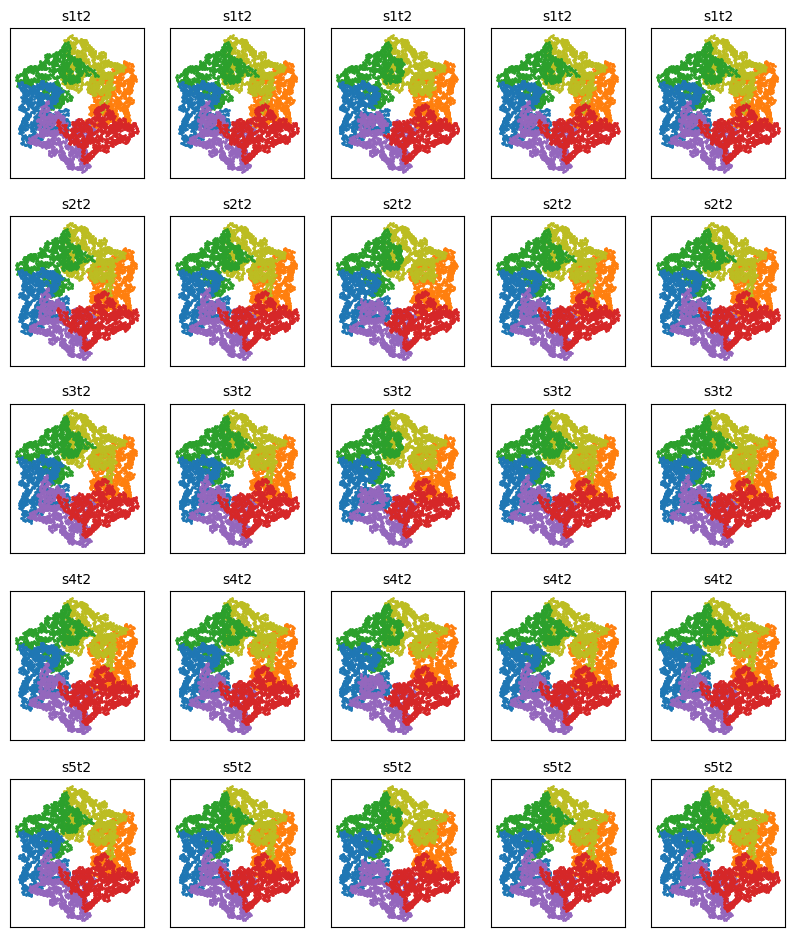

In [9]:
# Plot all structures
fig = plt.figure(figsize=(10, 12), dpi=100)

for i in range(len(s_pps_ref)):
    for j in range(len(s_pps_cycle)):
        ax = fig.add_subplot(len(s_pps_ref), len(s_pps_cycle), i+1 + j*len(s_pps_cycle))
        structure = labels[i][j][0][0][0]
        ax.set_title(structure, size = 10)

        chain_idx = load.chain_indices(chain_names, labels[i][j])
        for idx, col in zip(chain_idx, chain_colors):
            xs, ys, zs = xyz_cycle[i][j][idx,0], xyz_cycle[i][j][idx,1], xyz_cycle[i][j][idx,2]
            ax.scatter(xs, ys, s=1, color = col)

        ax.axis('scaled')
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()


## Elasticity calculations (cycle structures vs. reference structure)

## Calculating Strain energy density function $\Psi$

## $\Psi(\lambda_1, \lambda_2, \lambda_3) = \frac{\lambda}{2} \left[\sum\frac{{\lambda_i}^2 - 1}{2}\right]^2 + \mu \sum\left[\frac{{\lambda_i}^2-1}{2}\right]^2$

### $a = \left[\sum\frac{{\lambda_i}^2 - 1}{2}\right]^2$
### $b = \sum\left[\frac{{\lambda_i}^2-1}{2}\right]^2$
## $\Psi(\lambda_1, \lambda_2, \lambda_3) = \frac{\lambda}{2} a + \mu b $

In [10]:
E = []

for i in range(len(s_pps_ref)):
    print("\nReference", i+1)
    
    # Calculate deformation gradient
    F = np.zeros((len(s_pps_cycle), len(xyz_ref[i]), 3, 3))

    weights = elastic.intersect_nbhood_weights([xyz_ref[i]] + xyz_cycle[i], parameters=[9])
    for j in range(len(s_pps_cycle)):    
        structure_i = labels[i][j][0][0][0]

        print("Computing weights and F for structure", structure_i)
        D, A = elastic.intermediate_matrixes(weights, xyz_ref[i], xyz_cycle[i][j])
        F[j,:,:,:] = elastic.deformation_gradient(D, A)


    # Energy densities
    print("Calculating energy densities")
    stretches = []
    for j in range(len(s_pps_cycle)):
        gam_l, gam_n = elastic.lagrange_strain(F[j])
        st, st_axis = elastic.principal_stretches_from_g(gam_n)
        stretches.append(st)

    stretches = np.abs(stretches)**0.5
    a = np.sum((stretches**2-1)/2, axis = 2)**2
    b = np.sum(((stretches**2-1)/2)**2, axis = 2)

    lame_frst = 72976559.0446705 
    lame_scnd = 37593984.96240601
    psi = lame_frst/2 * a + lame_scnd * b
    
    kT = 1.380649e-23*300

    # Van der Waals volumes 
    print("Calculating atomic volumes")
    vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
    n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
    v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

    v = np.zeros(xyz_ref[i].shape[0])

    for j in range(len(v)):
        at = labels[i][0][j][1]

        v[j] = 4*np.pi*vdw[at]**3/3
        n_atom[at] += 1
        v_atom[at] += v[j]

    for at in list(vdw.keys()):
        print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

    # Protein volumes

    vol_dir = "data/volume/"
    files = np.array(ls(vol_dir))

    c = 0

    Vvdw, Vvoid = np.zeros(len(s_pps_cycle) * 6), np.zeros(len(s_pps_cycle) * 6)

    for name in s_cycle:
        str_files = [file for file in files if name in file]
        
        for chain in chain_names:
            str_ch_file = [file for file in str_files if "_" + chain in file][0]
            
            with open(vol_dir + str_ch_file, "r") as f:
                line = f.readlines()[8].split(" ")
                line = np.array(line)
                line = line[line != '']

                Vvdw[c] = float(line[3].replace(",", ".")) * 1e-30
                Vvoid[c] = float(line[2].replace(",", ".")) * 1e-30
            c+=1

    V = Vvdw + Vvoid

    # Calculating energy
    print("Calculating energy")
    
    E.append(np.zeros(psi.shape))
    chain_idx = load.chain_indices(chain_names, labels[i][0])
    
    c = 0
    for j in range(len(s_pps_cycle)):
        for idx in chain_idx:
            E[i][j, idx] = Vvdw[c] * v[idx] * psi[j, idx] / np.sum(v[idx])
            c += 1

    E[i] /= kT
    
    


Reference 1
Computing weights and F for structure s1t2
Computing weights and F for structure s2t2
Computing weights and F for structure s3t2
Computing weights and F for structure s4t2
Computing weights and F for structure s5t2
Calculating energy densities
Calculating atomic volumes
C: n = 3696 	v = 7.606192911651942e-26 	vf = 0.5759103600740639
O: n = 1848 	v = 2.718449940635405e-26 	vf = 0.20583010480267117
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v = 0 	vf = 0.0
N: n = 1848 	v = 2.882608551687326e-26 	vf = 0.2182595351232384
Calculating energy

Reference 2
Computing weights and F for structure s1t2
Computing weights and F for structure s2t2
Computing weights and F for structure s3t2
Computing weights and F for structure s4t2
Computing weights and F for structure s5t2
Calculating energy densities
Calculating atomic volumes
C: n = 3696 	v = 7.606192911651942e-26 	vf = 0.5759103600740639
O: n = 1848 	v = 2.718449940635405e-26 	vf = 0.20583010480267117
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v =

## Volume estimation of protomers

In [11]:
residues_energy_resh = np.zeros((len(s_pps_ref),
                                 len(residues_idx), 
                                 len(chain_names) * len(s_pps_cycle)))

residues_pos = np.zeros((len(s_pps_ref), 
                         len(residues_idx), 
                         3))

for ref in range(len(s_pps_ref)):
    residues_energy = np.zeros((len(residues_idx), 
                                len(chain_names), 
                                len(s_pps_cycle)))

    for i in range(len(labels[ref][0])):
        for k in range(len(s_pps_cycle)):
            resi = labels[ref][0][i][0][3][1]
            chain = labels[ref][0][i][0][2]
            i_ = residues_idx.index(resi)
            j_ = chain_names.index(chain)

            residues_energy[i_, j_, k] += E[ref][k, i]
            
            if labels[ref][0][i][0][4][0] == "CA":
                residues_pos[ref][i_] = xyz_cycle[ref][0][i]
        

    residues_energy[residues_energy == 0] = np.nan
    residues_energy_resh[ref] = residues_energy.reshape((len(residues_idx), 
                                                         len(chain_names) * len(s_pps_cycle)))


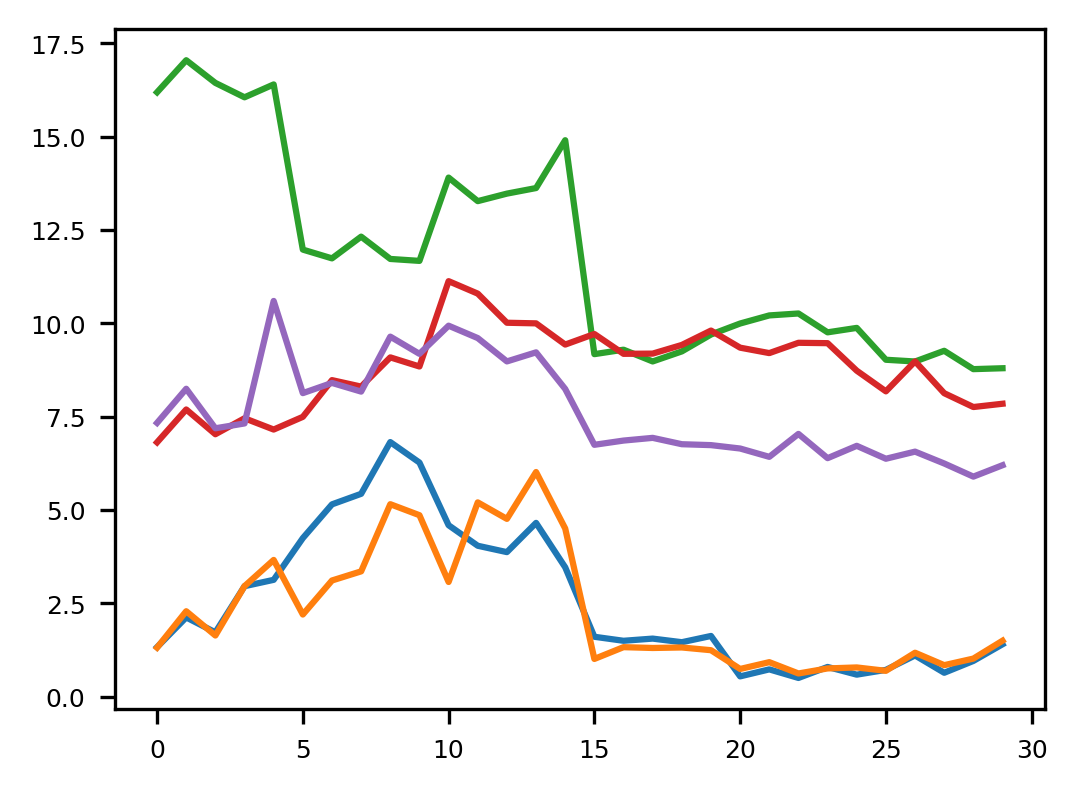

In [12]:
plt.figure(figsize = (4,3), dpi = 300)

plt.plot(np.nansum(residues_energy_resh, axis = 1).T)

# Finding mechanically active regions (variance threshold)

In [13]:
def fancy_scatter(ax, xdata, ydata, color, size, lw, alpha):
    ax.scatter(xdata, ydata, color = "black", s = size, lw = lw)
    ax.scatter(xdata, ydata, color = "white", s = size, lw = 0)
    ax.scatter(xdata, ydata, color = color, s = size, lw = 0, alpha = alpha)
    return


s0-At2
19 True
20 True
21 True
124 True
125 True
133 True
134 True
135 True
141 True
142 True
143 True
144 True
145 True
146 True
147 True
160 True
161 True
162 True
192 True
279 True
281 True
282 True
283 True
284 True
285 True
286 True
287 True
288 True
289 True
292 True
310 True
1.0

7PBQ
19 True
20 True
21 True
22 False
86 False
87 False
88 False
96 False
97 False
121 False
124 True
125 True
133 True
134 True
136 False
141 True
142 True
143 True
144 True
146 True
161 True
162 True
192 True
198 False
282 True
288 True
289 True
290 False
292 True
304 False
310 True
0.6451612903225806

8EFV
49 False
87 False
88 False
91 False
129 False
132 False
146 True
147 True
148 False
150 False
183 False
184 False
199 False
200 False
201 False
236 False
241 False
276 False
277 False
280 False
283 True
284 True
289 True
290 False
292 True
293 False
323 False
328 False
329 False
330 False
0.2

AF_model
19 True
20 True
21 True
48 False
49 False
86 False
87 False
95 False
117 False
125 True
133 True

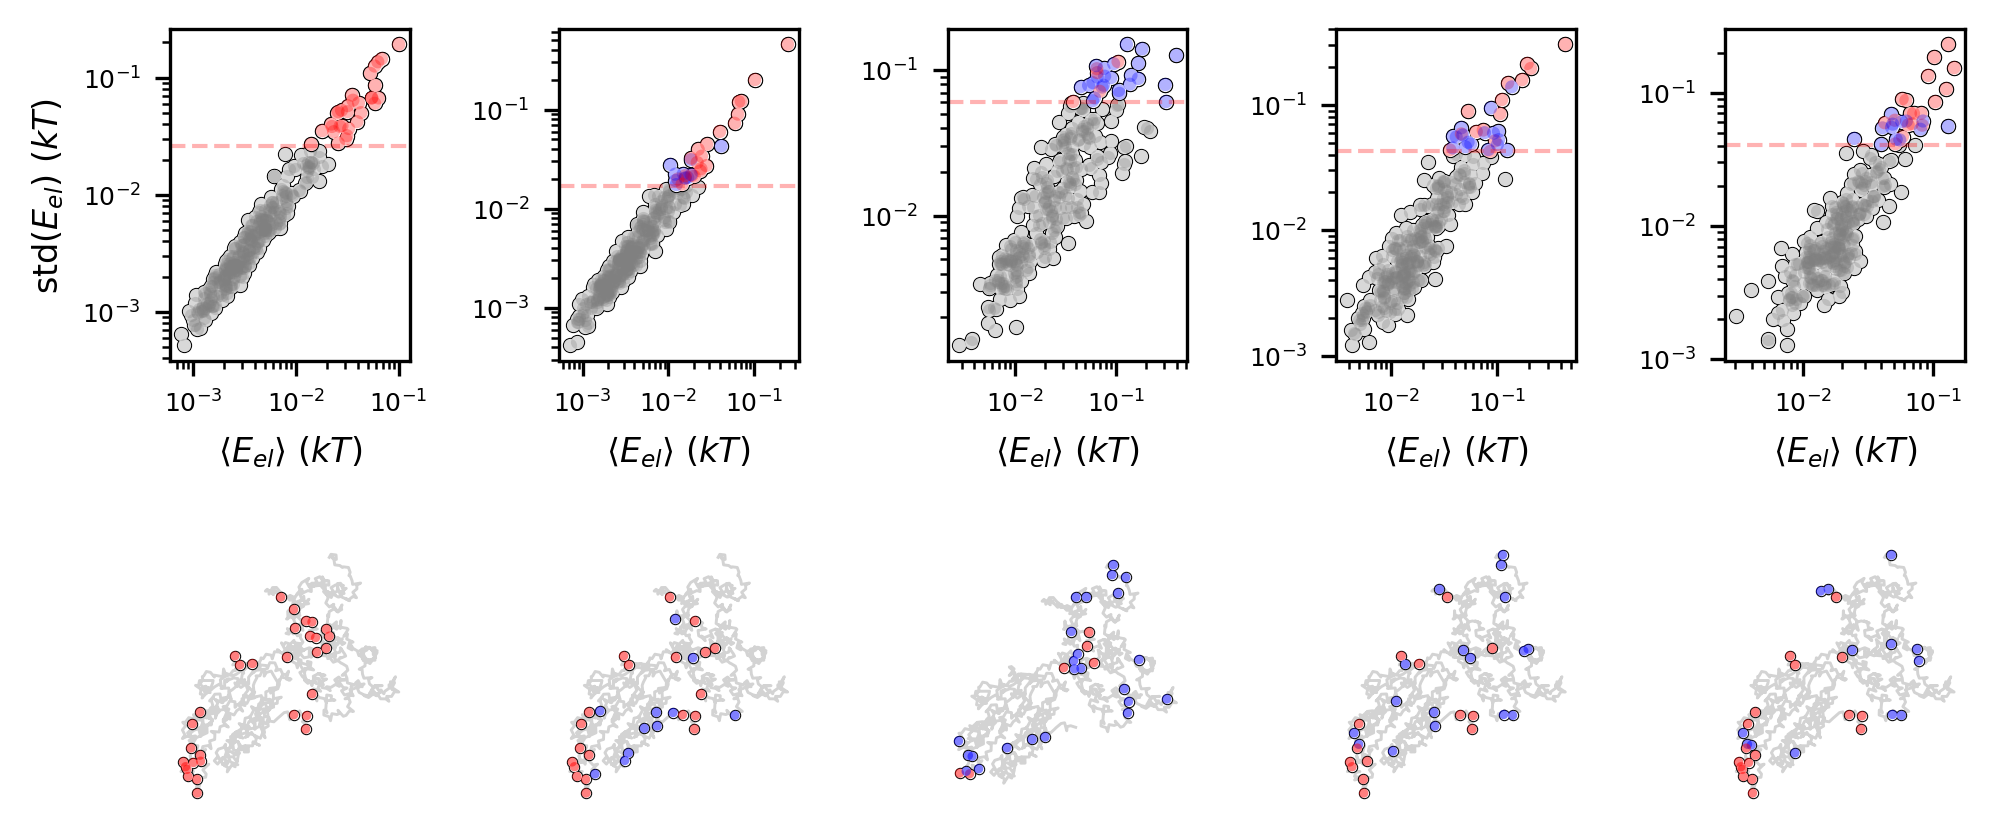

In [16]:
fig = plt.figure(figsize = (2*WIDTH, 3), dpi = 300)

mech_act_0 = []
for ref in range(len(s_pps_ref)):
    size = 10

    ax = fig.add_subplot(2, len(s_pps_ref), ref + 1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("$\\langle E_{el} \\rangle$ $(kT)$")
    if ref == 0:
        ax.set_ylabel("${\\rm std}(E_{el})}$ $(kT)$")
    

    fancy_scatter(ax,
                  np.mean(residues_energy_resh[ref], axis = 1),
                  np.std(residues_energy_resh[ref], axis = 1),
                  color = "gray", size = size, alpha = .3, lw = 0.5)

    var_trsh = np.nanquantile(np.nanstd(residues_energy_resh[ref], axis = 1), 0.9)
    
    mech_active = np.nanstd(residues_energy_resh[ref], axis = 1) > var_trsh
        
    
    ax.axhline(var_trsh, lw = 1, ls = "dashed", color = "red", alpha = .3)

    print("\n" + s_ref[ref])
    mech_color = []
    pos = 0
    tot = 0
    for i in range(len(mech_active)):
        if mech_active[i]:
            if ref == 0:
                mech_act_0.append(residues_idx[i])
            
            print(str(residues_idx[i]), residues_idx[i] in mech_act_0)
            if residues_idx[i] in mech_act_0:
                mech_color += ["red"]
                pos += 1
            else:
                mech_color += ["blue"]
            tot += 1
    
    print(pos/tot)
    
    fancy_scatter(ax,
                  np.mean(residues_energy_resh[ref][mech_active], axis = 1),
                  np.std(residues_energy_resh[ref][mech_active], axis = 1),
                  color = mech_color, size = size, alpha = .3, lw = 0.5)

            
    ax = fig.add_subplot(2, len(s_pps_ref), ref + 1 + len(s_pps_ref))
    
    # plotting structure coordinates
    chain_idx = load.chain_indices(chain_names, labels[ref][0])
    ys, zs = xyz_cycle[ref][0][chain_idx[0],1], xyz_cycle[ref][0][chain_idx[0],2]
    ax.plot(ys, zs, color = "lightgray", zorder = -1, lw = .7)


    ys_res, zs_res = residues_pos[ref,mech_active,1], residues_pos[ref,mech_active,2]
    #ax.scatter(ys_res, zs_res, s = 2, color = mech_color)
    fancy_scatter(ax, ys_res, zs_res,
                  color = mech_color, size = 5, alpha = .5, lw = 0.5)

    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("scaled")
    plt.box(False)

    
plt.tight_layout()
